# Linear Regression
Regression is an approach to finding function $f(x)$, that models the conditional expectation of $Y$ given X:

$$
f(x) = E[Y|X=x]
$$

In linear regression, we assume that this function is globally linear (see [parent README.md](../README.md) for the meaning of this.).

In regression, minimizing the sum of square residuals by finding the the minimizing set of parameters is called the least squared solution,
and the regression function when viewed in a statistical sense is the solution to least squares.

For linear regression,there is an analytical solution derived from linear algebra:
$$
\hat{\vec{b}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T*\vec{y}
$$

Alternatively, when direct matrix inversion is computationally prohibitive (due to its cubic complexity in the number of features, O(p³)), iterative methods like (mini-)batch gradient descent are preferred (O(np) per iteration). 

While the analytical solution, in its purest form, requires a global computation on the entire dataset, making it difficult to directly parallelize in the same way as gradient descent is and the tool ecosystem is very mature for optimizing in this way.

Assume here * refers to matrix multiplication, unless otherwise noted.


$$
Loss = (\vec{y} - \mathbf{X}\vec{b})^T(\vec{y} - \mathbf{X}\vec{b}) \\
\forall (\forall \mathbf{X}_{b} \in \mathbf{X}) \in N_{trainiter} \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M *\nabla_{\hat{\vec{b}}} Loss \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M * 2\mathbf{X}_b^T*(\vec{y} - \mathbf{X}_b \hat{\vec{b}})
$$

## Assumptions:
* Can have additive error, $ y = f(x) + \epsilon $, and uncorrelated with x ( $\epsilon \perp X$) constant variance and usually $\epsilon  \sim N(0,\sigma^2)$. This helps for further statistical analysis.
* Globally linear f(x)

## Example:
Lets generate some data using a linear model with additive error, and use both the gradient based and analytical model to see if we can get the original parameters.


In [38]:
import numpy as np

coefficients = np.array([0.1, 5]).T
bias = np.array([3])

noise = np.random.normal(0, 1, (1000))

input = np.random.uniform(-1.0, 1.0, (1000, 2))

output = noise + input @ coefficients + bias

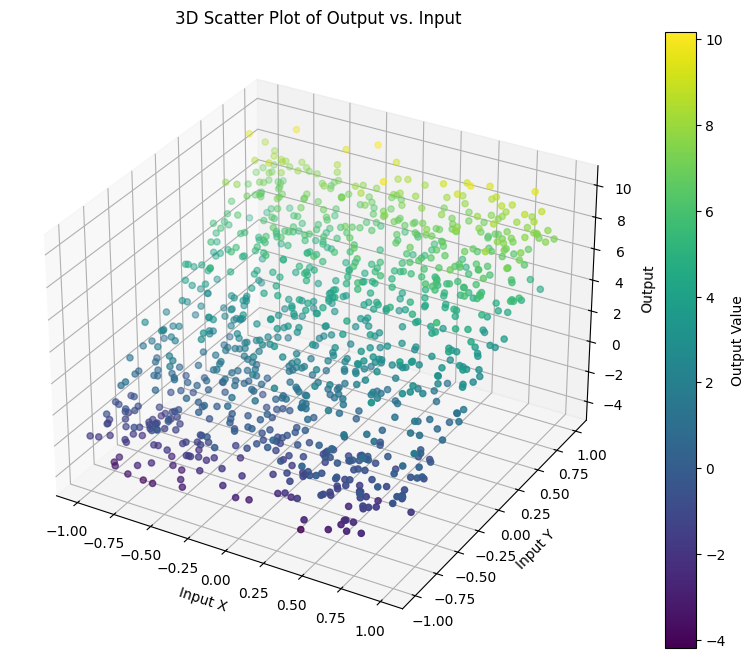

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(input[:, 0], input[:, 1], output, c=output, cmap='viridis', marker='o')
ax.set_xlabel("Input X")
ax.set_ylabel("Input Y")
ax.set_zlabel("Output")
ax.set_title("3D Scatter Plot of Output vs. Input")
fig.colorbar(scatter, label="Output Value")
plt.show()

In [40]:
# analytical approach:
inputWithBias = np.hstack([input, np.ones((input.shape[0], 1))])
coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
print(f"Estimated coefficients: {coefficientsEstimateAnalytical[:-1]}, true coefficients: {coefficients}")
print(f"Estimated bias: {coefficientsEstimateAnalytical[-1]}, true bias: {bias}")
mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
print(f"mse: {mse}")

Estimated coefficients: [0.07895642 5.05634414], true coefficients: [0.1 5. ]
Estimated bias: 3.0178368476847326, true bias: [3]
mse: 1.0139526456526753


In [41]:
# gradient based approach:
coefficientsEstimateGradient = np.random.normal(0, 1, (3))
batchSize = 10
learningRate = 0.01
epochs = 10
for epoch in range(epochs):
    for batch in range(inputWithBias.shape[0] // batchSize):
        batchInput = inputWithBias[batchSize * batch : batchSize * batch + batchSize]
        batchOutput = output[batchSize * batch : batchSize * batch + batchSize]
        coefficientsEstimateGradient += learningRate * 1 / batchInput.shape[0] * 2 * batchInput.T @ (batchOutput - batchInput @ coefficientsEstimateGradient)
    epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
    print(f"end epoch {epoch + 1}, mse: {epochalMSE}")

end epoch 1, mse: 3.27354411450761
end epoch 2, mse: 1.5737899168398253
end epoch 3, mse: 1.1559546455874323
end epoch 4, mse: 1.0507290373935003
end epoch 5, mse: 1.0238744204793964
end epoch 6, mse: 1.016881665897664
end epoch 7, mse: 1.0149960326463012
end epoch 8, mse: 1.0144562290919676
end epoch 9, mse: 1.0142866066198708
end epoch 10, mse: 1.0142263385823205


In [ ]:
print(f"gradient coefficients + intercept: {coefficientsEstimateGradient}, and analytical{ coefficientsEstimateAnalytical}")

import statsmodels.formula.api as smf
import pandas as pd
df = pd.DataFrame(input, columns=['feature_1', 'feature_2'])
df['target_output'] = output
formula = 'target_output ~ feature_1 + feature_2'
model_formula = smf.ols(formula=formula, data=df)
results_formula = model_formula.fit()
print("\n--- Statsmodels OLS Results---")
print(results_formula.params)

gradient coefficients + intercept: [0.09363499 5.04172706 3.00658424], and analytical[0.07895642 5.05634414 3.01783685]

--- Statsmodels OLS Results (Formula API) ---
Intercept    3.017837
feature_1    0.078956
feature_2    5.056344
dtype: float64


This shows they get to the same place.

## Goodness of fit
The goal of goodness-of-fit tests in linear regression is to assess how well the model's assumptions hold and whether the model adequately captures the relationship between the predictors and the response. This goes beyond just minimizing the loss function; it's about ensuring the validity of the model and its interpretations.

The fundamental approach is to use a model output ($\hat{\vec{y}}$) vs residual ($\hat{\vec{y}} - \vec{y}$) plot, this is expected to be a random scatter centered around 0.

If it's not (e.g., a curved pattern or a non-constant variance (not Homoscedasticity)) one can dig further to see which features are non linear by considering feature vs residual plot. 

One could then try to transform the feature/output to have a more linear relationship, or consider another model.


### For interpretability
It's important for interpretability and to make inferences about coefficients to look at and check for multi-colinearity and to look at and check for normality of errors.

#### Multi - collinearity
This violates one of the assumptions that each feature is independent from another $P(X_i | X_j) = P(X_i), \forall i, j$ where $i \neq j$.

Two approaches:

##### VIF
VIF is the Variance Inflation Factor (VIF). It is performing linear regression treating the feature for which you are finding the VIF for as dependent varaible to be predicted by all the other features, then computing $ 1 / (1 - R^2)$ for this model. $R^2$ is 1 - sum of square residuals / total sum of squares, it compares how off we are from predicting the feature over a baseline of just using the average, where 1 means the model is 0 error, than just predicting and 0 means the model explains none of the variance in the VIF feature; it's no better than simply predicting the mean, then The VIF is the reciprocal of (1 - R²), which quantifies how well the model could get on without the feature (since it could be linearly constructed from the others). R² larger is smallest error, so then 1 - R² flips this and reciprical flips it again and R² then larger is smaller error, which would mean that the feature is redundant.

We compute VIFs for each feature and A VIF > 5 (or 10, depending on the context) suggests problematic multicollinearity.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

After you find features with VIFs, you can look at correlation matrix to find the variables that you can consider dropping then recheck for VIF values. You don't necessarily have to do this for just prediction usage but for interpretability of the coefficients. You could also combine them (average or otherwise), or even use regularization though the simple interpretability that came from the assumptions of independent factors is not valid anymore.

##### Correlation matrix
One could also directly examine the correlation matrix of the predictors. The correlation matrix is derived from covariance matrix, its the covariance matrix divided by the product of the standard deviations of the two variables in each pair- it normalizes the covariance so its always between -1 and 1, removing the scaling differences that would otherwise make covariance a good option to compare how features "move together" which is the condition of multi collinearity that we seek.

Pairwise correlation:
$\rho_{jk} = \frac{\sum_{i=1}^{n} (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)}{\sigma_i * \sigma_j}$


Efficient Linear Algebra for correlation matrix:


$$
\vec{\bar{x}} = average(\mathbf{X}, dim=0).reshape(1, \mathbf{X}.shape[1]) \\
\mathbf{X_{demenaed}} = \mathbf{X} -\vec{\bar{x}} \\ 
Cov = (\mathbf{X_{demeaned}}^T*\mathbf{X_{demeaned}}) / (\mathbf{X}.shape[0] - 1) \\
StdDevInv = 1 / sqrt(diagnol(Cov)) \\
Correlation = Cov *_{element} StdDevInv.reshape(1,\mathbf{X}.shape[1]) *_{element} StdDevInv.reshape(\mathbf{X}.shape[1], 1)
$$

Here we make use of broadcasting, as Numpy implements it.

Look for high pairwise correlations (e.g., |r| > 0.8 or 0.9), remove those with very high.

#### Normality of errors
To see whether errors are normal, one could plot them with a histogram and see if it's the traditional bell shaped curve, centered around 0 or use normal Q-Q (Quantile - Quantile) plot, where you plot values in Y axis and the standard normal z score for the porportion of sample values below that (altered a bit to avoid infinity z scores) (inverse CDF of standard normal). A 45-degree reference line from 0 is often added and how well the plotted points lines up and where indicate how standard normal the residuals actually are, a straight line indicates a linear relationship though the standard deviation and mean are the slope and offset respectively.

Tests like the Shapiro-Wilk test or Anderson-Darling test provide a p-value to formally test the null hypothesis that the residuals are normally distributed. However, visual inspection with histograms and especially Q-Q plots is often preferred, particularly for understanding *how* the distribution deviates from normality if it does.

If they're not, may want to transform the response variable, for example taking a $log(Y)$ is most common or square root (particulary if its right skew which means mean is greater than median), if it's left skew you can do $1 - log(y)$.

Or consider generalized linear models (GLMs) which do not assume normal 0 centered noise.

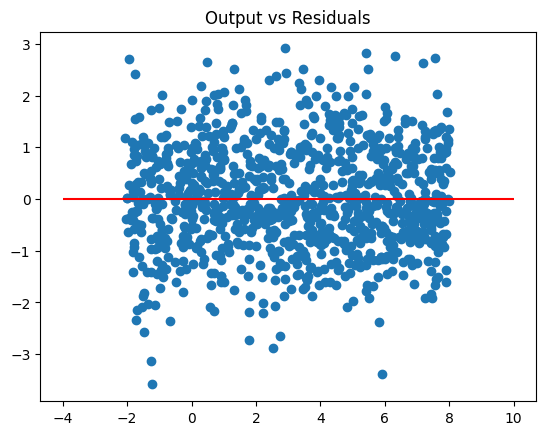

In [19]:
## goodness of fit
residuals = output - (inputWithBias @ coefficientsEstimateGradient)
plt.scatter((inputWithBias @ coefficientsEstimateGradient), residuals)
plt.hlines(0, -4, 10, colors="red")
plt.title("Output vs Residuals");

In [30]:
# looks pretty good, which it should, constant variance 0 noise was used to generate it
# for interpretability, lets do VIF
# VIF = 1 / (1 - R^2) for R^2 value of using other features used regress to feature we are getting VIF from
# R^2 = 1 - SSR / SST where SSR is sum(residuals^2) and SST is sum((y - mean(y))^2)
def VIF(featureIndex, modelInput):
    x = np.hstack([modelInput[:, :featureIndex], modelInput[:, featureIndex + 1:]])
    y = modelInput[:, featureIndex]
    xWithBias = np.hstack([x, np.ones((x.shape[0], 1))])
    coefficients = np.linalg.inv(xWithBias.T @ xWithBias) @ xWithBias.T @ y
    modelOutput = xWithBias @ coefficients
    ssr = np.sum((y - modelOutput)**2)
    residuals = y - modelOutput
    sst = np.sum((y - np.mean(y))**2)
    rSquared = 1 - ssr / sst
    return 1 / (1 - rSquared)

for i in range(input.shape[1]):
    print(f"VIF of index {i}: {VIF(i, input)}")

def correlationMatrix(modelInput):
    means = np.mean(modelInput, axis=0).reshape(1, modelInput.shape[1])
    demeanedX = modelInput - means
    covariance = (demeanedX.T @ demeanedX) / (modelInput.shape[0] - 1)
    standardDeviationInv = 1/ np.sqrt(np.diag(covariance))
    return covariance * standardDeviationInv.reshape(1, modelInput.shape[1]) * standardDeviationInv.reshape(1, modelInput.shape[1]) 

print("Correlation matrix:\n", correlationMatrix(input))

VIF of index 0: 1.000023182707999
VIF of index 1: 1.000023182707999
Correlation matrix:
 [[ 1.         -0.00470701]
 [-0.00492503  1.        ]]


In [36]:
# looks like the VIFs indicate a low multi collinearity
# also correlation matrix is pretty much identity
# which is expected
# Using numpy's built-in function
corr_matrix_np = np.corrcoef(input, rowvar=False)
# 'rowvar=False' means columns are variables, rows are observations
print("Correlation matrix (using np.corrcoef):\n", corr_matrix_np)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # To add the intercept term

X_with_const = add_constant(input)
print("VIFs from statsmodels:\n", [variance_inflation_factor(X_with_const, i + 1) for i in range(input.shape[1])])

## so we are on track, though the correlation coefficient was off, its in the 4th decimal place in a value that ranges from -1 to 1
# so we will chalk it up to rounding errors and exact procedure

Correlation matrix (using np.corrcoef):
 [[ 1.         -0.00481479]
 [-0.00481479  1.        ]]
VIFs from statsmodels:
 [np.float64(1.000023182707999), np.float64(1.000023182707999)]


In [ ]:
## (tk) validation, hyper parameters, feature selection, interpretability
## (tk) industry standard library for this